## Policy Note

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [119]:
# Clean USA data

# read in data 
dc_USA = pd.read_excel(f"nomBorrow_USA.xls", index_col='period')
pb_USA = pd.read_excel(f"nomGDP_USA.xls", index_col='period')
inn_USA = pd.read_excel(f"nomInterest_USA.xls", index_col='period')

# q_def = pd.read_excel(f"deflate_quarter.xls", index_col='period')
# a_def = pd.read_excel(f"deflate_annual.xls", index_col='period')

# # divide inflation
# q_def = q_def/100
# a_def = a_def/100

# # merge with deflator
# dc_USA = dc_USA.merge(a_def, left_index=True, right_index=True)
# pb_USA = pb_USA.merge(q_def, left_index=True, right_index=True)
# inn_USA = inn_USA.merge(q_def, left_index=True, right_index=True)

# adjust for inflation
# dc_USA['dc_real'] = dc_USA['BOGZ1FU315000005A'] / dc_USA['GDPDEF_NBD20230101']
# pb_USA['pb_real'] = pb_USA['GDP'] / pb_USA['GDPDEF_NBD20230101']
# inn_USA['inn_real'] = inn_USA['A091RC1Q027SBEA'] / inn_USA['GDPDEF_NBD20230101']

# dont adjust for inflation
dc_USA['dc_real'] = dc_USA['BOGZ1FU315000005A'] 
pb_USA['pb_real'] = pb_USA['GDP'] 
inn_USA['inn_real'] = inn_USA['A091RC1Q027SBEA']

#keep only useful and adjust units
dc_USA = dc_USA['dc_real']*1000000
pb_USA = pb_USA['pb_real']*1000000000
inn_USA = inn_USA['inn_real']*1000000000

# Process index for each DataFrame
dc_USA.index = pd.to_datetime(dc_USA.index, format='%Y')
pb_USA.index = pd.PeriodIndex(pb_USA.index, freq='Q').to_timestamp()
inn_USA.index = pd.to_datetime(inn_USA.index, format='%Q')

# Sum the data annually
inn_USA = inn_USA.resample('A').sum()

# only 1975 onwards
dc_USA = dc_USA.loc['1975':]
pb_USA = pb_USA.loc['1975':]
inn_USA = inn_USA.loc['1975':]

# Convert index to string format before saving to Excel
dc_USA.index = dc_USA.index.strftime('%Y')
pb_USA.index = pb_USA.index.strftime('%m/%Y')
inn_USA.index = inn_USA.index.strftime('%Y')

# save as xlsx
dc_USA.to_excel('deficitcomptable.USA.xlsx')
pb_USA.to_excel('ProdBrut.USA.xlsx')
inn_USA.to_excel('interest.USA.xlsx')

In [120]:
def process_country_data(country_code):
    # Load Excel files into DataFrames
    dc = pd.read_excel(f"deficitcomptable.{country_code}.xlsx", index_col='period')
    pb = pd.read_excel(f"ProdBrut.{country_code}.xlsx", index_col='period')
    inn = pd.read_excel(f"interest.{country_code}.xlsx", index_col='period')
    PIB = pd.read_excel("PIB.xlsx")

    # Process index for each DataFrame
    dc.index = pd.to_datetime(dc.index, format='%Y')
    pb.index = pd.PeriodIndex(pb.index, freq='Q').to_timestamp()
    inn.index = pd.to_datetime(inn.index, format='%Y')

    # Sum the data annually
    pb = pb.resample('A').sum()

    # Adjust indexes to be year only
    pb.index = pb.index.year
    dc.index = dc.index.year
    inn.index = inn.index.year

    # Filter and process PIB data
    PIB = PIB[PIB['country'] == country_code]
    PIB.index = PIB['year']
    PIB = PIB[['debtgdp']]

    # Merge DataFrames by year index
    df = pd.merge(pb, dc, left_index=True, right_index=True)
    df = pd.merge(df, PIB, left_index=True, right_index=True)
    df = pd.merge(df, inn, left_index=True, right_index=True)

    # Rename columns
    df.columns = ['Produit intérieur brut', 'Capacité (+) ou besoin (-)', 'debtgdp', 'interest']

    # Adjust units
    df['Produit intérieur brut'] = df['Produit intérieur brut'] / 1000
    df['Capacité (+) ou besoin (-)'] = df['Capacité (+) ou besoin (-)'] / 1000
    df['interest'] = df['interest'] / 1000

    df['interest Percent of GDP'] = (df['interest'] / df['Produit intérieur brut'])*-100


    # Calculate additional metrics
    df['dette'] = df['debtgdp'] * df['Produit intérieur brut']
    df['variation dette'] = df['dette'].diff()
    df['adjust flux'] = df['variation dette'] - (df['Capacité (+) ou besoin (-)'] * -1)
    df['adjust flux sur PIB'] = (df['adjust flux'] / df['Produit intérieur brut']) * 100
    df['Deficit sur PIB'] = (df['Capacité (+) ou besoin (-)'] * -1 / df['Produit intérieur brut']) * 100
    df['plus ASF'] = (((df['Capacité (+) ou besoin (-)'] * -1 - df['interest']) / df['Produit intérieur brut']) * 100) + df['adjust flux sur PIB']
    df['déficit primaire comptable en % pib '] = (((df['Capacité (+) ou besoin (-)'] * -1 - df['interest']) / df['Produit intérieur brut']) * 100)

    # Calculate term r-g
    left = df['Produit intérieur brut'].pct_change() * df['dette'] / df['Produit intérieur brut']
    right = df['interest'] / df['Produit intérieur brut']
    df['term r-g'] = (right - left) * 100

    df['debt to GDP'] = (df['dette']/ df['Produit intérieur brut'])*100

    return df



In [121]:
def plot_data(df, country_code):
    # RED BLUE GRAPH
    colors = ['blue', 'red', 'orange']  # Colors for each stack
    ax = df[['adjust flux sur PIB', 'Deficit sur PIB', 'interest Percent of GDP']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["adjustement stock flux", "déficit public", "charge d'interet/PIB"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Composantes deficit primaire - {country_code}')
    plt.xlabel('Annee')
    plt.ylabel('Fraction de PIB')

    # Save the plot
    plt.savefig(f'{country_code}_Fig1.png')
    plt.show()
    plt.close()

    # RED GREEN GRAPH
    colors = ['red', 'green']  # Red for 'plus ASF', Green for 'term r-g'
    ax = df[['plus ASF', 'term r-g']].plot(kind='bar', stacked=True, color=colors)

    plt.legend(["déficit primaire + ASF", "terme r-g"])

    # Set x-ticks to display every other year
    xticks = ax.get_xticks()
    ax.set_xticks(xticks[::2], minor=False)
    ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
    ax.yaxis.set_major_formatter(PercentFormatter(100.0))

    plt.title(f'Dynamique de la dette - {country_code}')
    plt.xlabel('Annee')
    plt.ylabel('Fraction de PIB')

    # Save the plot
    plt.savefig(f'{country_code}_Fig2.png')
    plt.show()  
    plt.close()


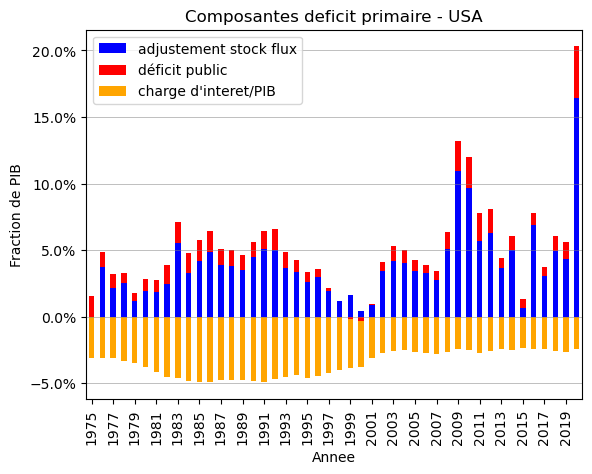

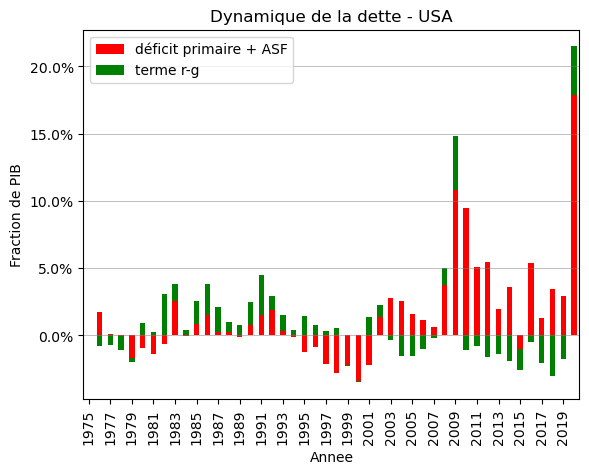

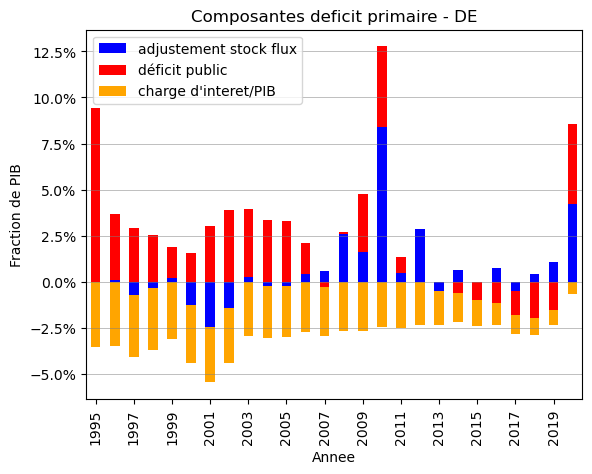

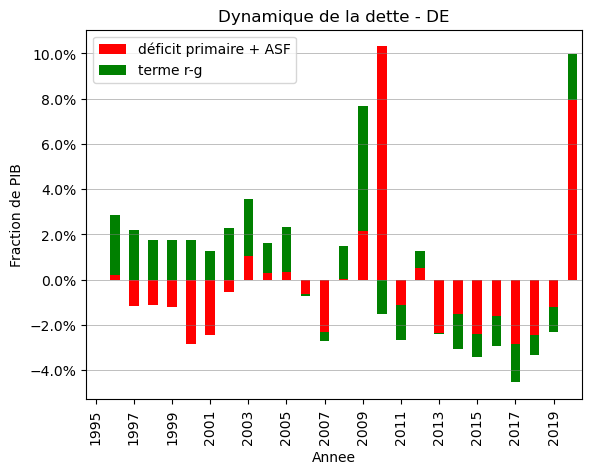

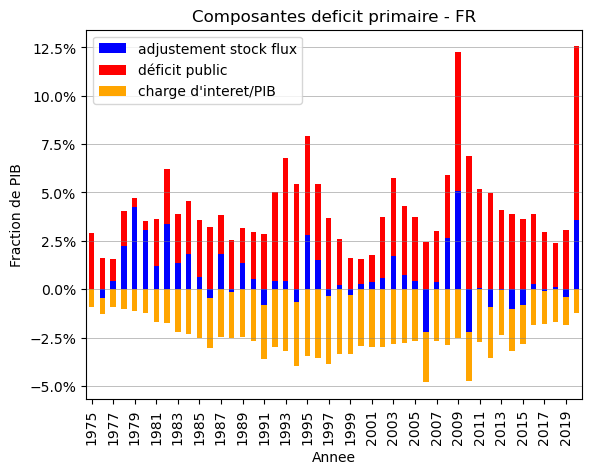

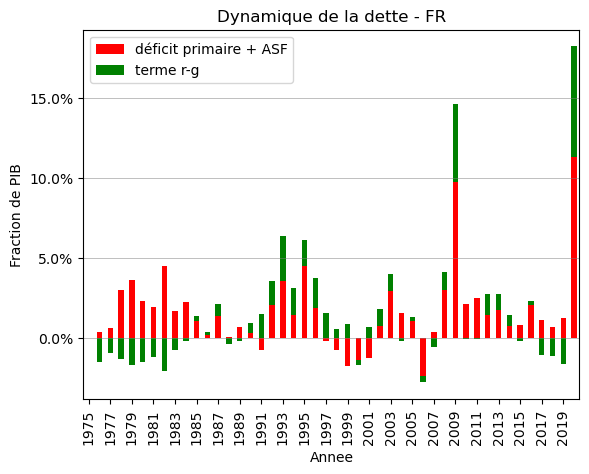

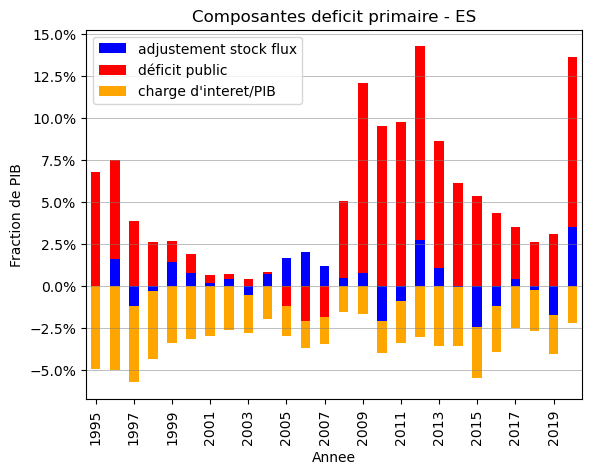

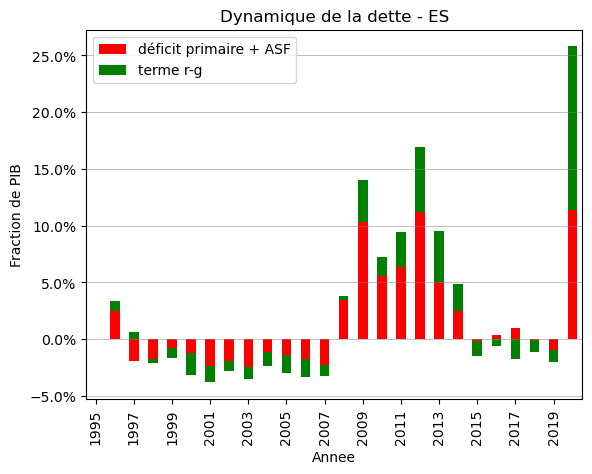

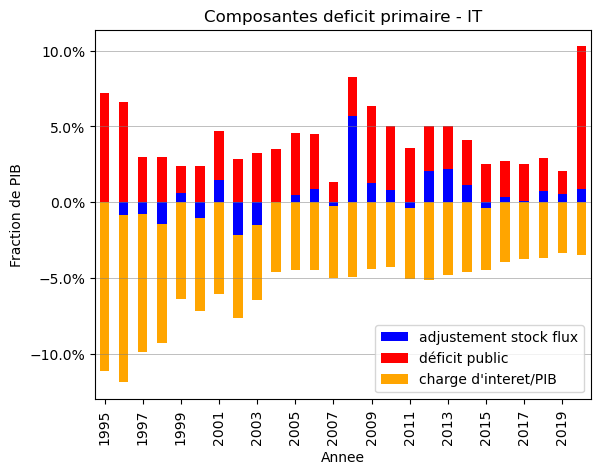

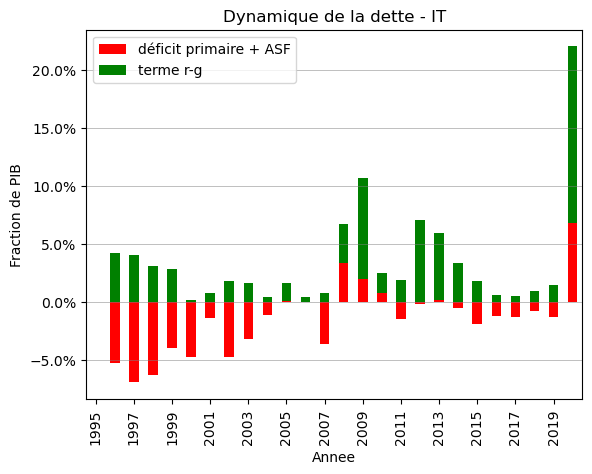

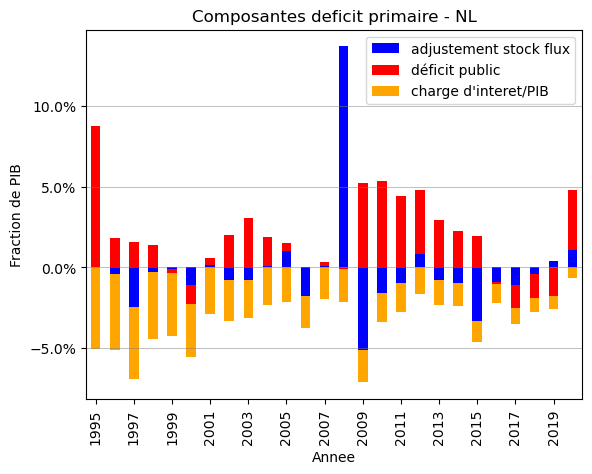

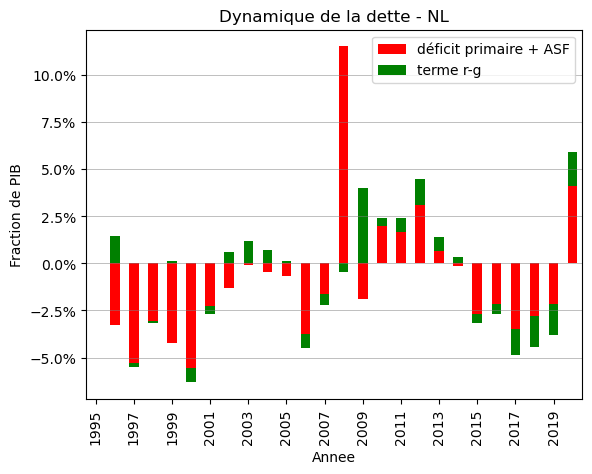

In [122]:
# List of country codes
countries = ['USA','DE', 'FR', 'ES', 'IT', 'NL']

# Process data and plot for each country
for country in countries:
    df = process_country_data(country)
    globals()[f'df_{country}'] = df  # Create DataFrame variable for each country
    plot_data(df, country)

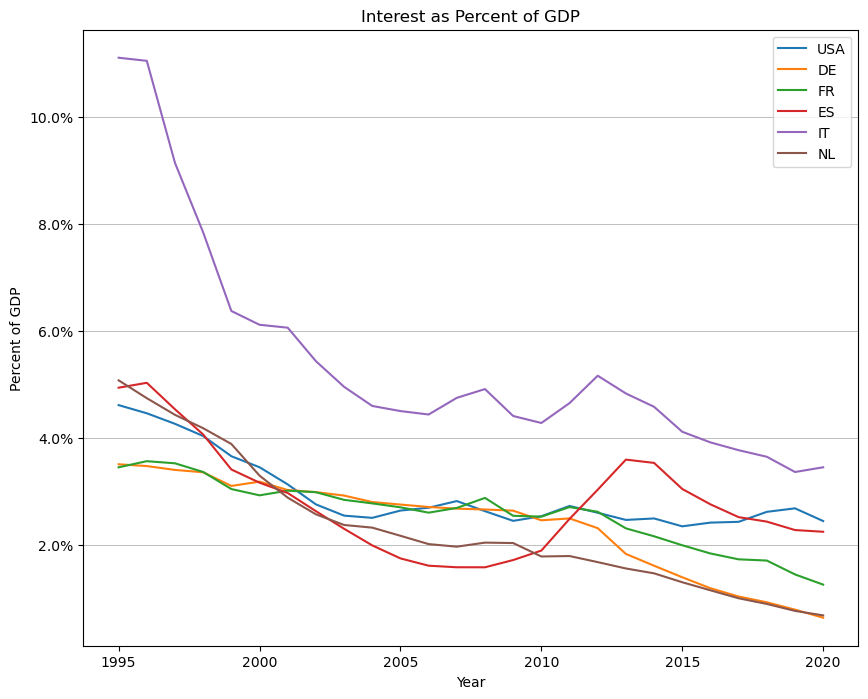

In [123]:
plt.figure(figsize=(10, 8))  # Set the figure size for better readability

ax = None  # Initialize ax for later use
for country in countries:
    # Filter the dataframe to include only the years from 1995 onwards
    df_filtered = globals()[f'df_{country}'][(globals()[f'df_{country}'].index >= 1995)]
    
    # Plot the negative interest percent of GDP
    ax = (-df_filtered['interest Percent of GDP']).plot(label=country)

plt.legend()

# Adding horizontal grey lines across the plot for better readability
ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)

# Set y-axis formatter to percentage
ax.yaxis.set_major_formatter(PercentFormatter(100.0))

plt.title('Interest as Percent of GDP')
plt.xlabel('Year')
plt.ylabel('Percent of GDP')
#plt.savefig('Interest_GDP.png')
plt.show()
plt.close()

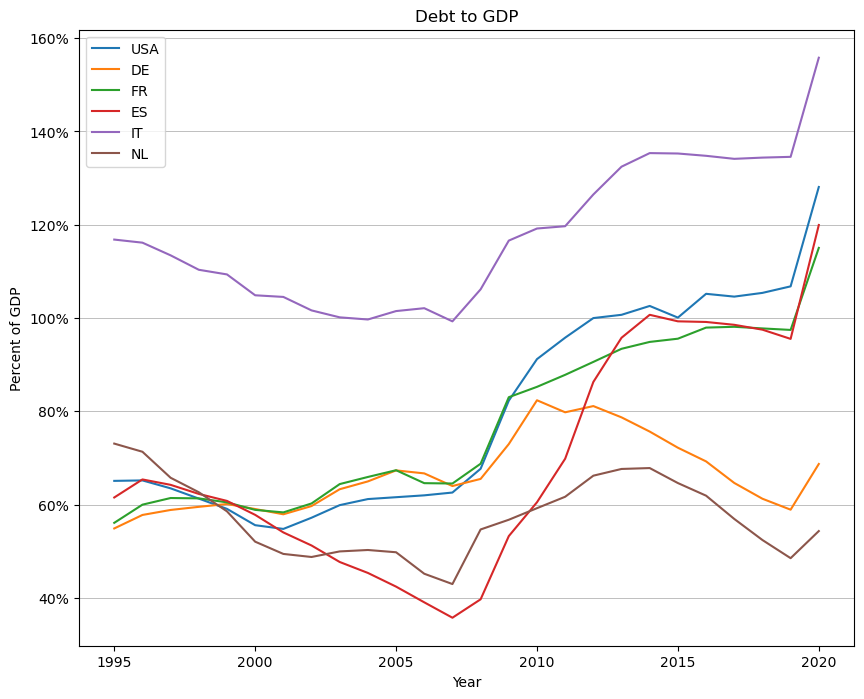

In [124]:
plt.figure(figsize=(10, 8))  # Set the figure size for better readability

ax = None  # Initialize ax for later use
for country in countries:
    # Filter the dataframe to include only the years from 1995 onwards
    df_filtered = globals()[f'df_{country}'][(globals()[f'df_{country}'].index >= 1995)]
    
    # Plot the negative interest percent of GDP
    ax = (df_filtered['debt to GDP']).plot(label=country)

plt.legend()

# Adding horizontal grey lines across the plot for better readability
ax.yaxis.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)

# Set y-axis formatter to percentage
ax.yaxis.set_major_formatter(PercentFormatter(100.0))

plt.title('Debt to GDP')
plt.xlabel('Year')
plt.ylabel('Percent of GDP')
#plt.savefig('PercentGDP.png')
plt.show()
plt.close()